In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder , StandardScaler,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, classification_report, confusion_matrix,f1_score
from sklearn.metrics import accuracy_score,ConfusionMatrixDisplay
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pickle
import joblib

In [2]:
data = pd.read_csv("Data/fraud_data.csv")
data = data.drop('Unnamed: 0',axis=1)
print("Shape is" , data.shape)
data.head()

Shape is (180519, 14)


,Type,Delivery Status,Late_delivery_risk,Category Name,Customer City,Customer Segment,Department Name,Market,Order Country,Order Item Quantity,Order Region,Product Price,Shipping Mode,FraudOrder
0,DEBIT,Advance shipping,0,Sporting Goods,Caguas,Consumer,Fitness,Pacific Asia,Indonesia,1,Southeast Asia,327.75,Standard Class,False
1,TRANSFER,Late delivery,1,Sporting Goods,Caguas,Consumer,Fitness,Pacific Asia,India,1,South Asia,327.75,Standard Class,False
2,CASH,Shipping on time,0,Sporting Goods,San Jose,Consumer,Fitness,Pacific Asia,India,1,South Asia,327.75,Standard Class,False
3,DEBIT,Advance shipping,0,Sporting Goods,Los Angeles,Home Office,Fitness,Pacific Asia,Australia,1,Oceania,327.75,Standard Class,False
4,PAYMENT,Advance shipping,0,Sporting Goods,Caguas,Corporate,Fitness,Pacific Asia,Australia,1,Oceania,327.75,Standard Class,False


In [3]:
data = data.rename(columns=lambda x: x.replace(' ', '_'))
data.columns

Index(['Type', 'Delivery_Status', 'Late_delivery_risk', 'Category_Name',
       'Customer_City', 'Customer_Segment', 'Department_Name', 'Market',
       'Order_Country', 'Order_Item_Quantity', 'Order_Region', 'Product_Price',
       'Shipping_Mode', 'FraudOrder'],
      dtype='object')

In [4]:
data[data['FraudOrder'] == True]

,Type,Delivery_Status,Late_delivery_risk,Category_Name,Customer_City,Customer_Segment,Department_Name,Market,Order_Country,Order_Item_Quantity,Order_Region,Product_Price,Shipping_Mode,FraudOrder
10,TRANSFER,Shipping canceled,0,Sporting Goods,Caguas,Corporate,Fitness,Pacific Asia,Japón,1,Eastern Asia,327.750000,Second Class,True
24,TRANSFER,Shipping canceled,0,Sporting Goods,Billings,Corporate,Fitness,Pacific Asia,Australia,1,Oceania,327.750000,Second Class,True
183,TRANSFER,Shipping canceled,0,Electronics,Freeport,Consumer,Footwear,USCA,Estados Unidos,3,US Center,44.990002,Standard Class,True
184,TRANSFER,Shipping canceled,0,Cardio Equipment,Fort Washington,Consumer,Footwear,USCA,Estados Unidos,3,West of USA,99.989998,Standard Class,True
185,TRANSFER,Shipping canceled,0,Cardio Equipment,Bakersfield,Consumer,Footwear,USCA,Estados Unidos,3,West of USA,99.989998,Standard Class,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180274,TRANSFER,Shipping canceled,0,Fishing,Caguas,Corporate,Fan Shop,Pacific Asia,Japón,1,Eastern Asia,399.980011,Second Class,True
180309,TRANSFER,Shipping canceled,0,Fishing,Modesto,Consumer,Fan Shop,Pacific Asia,China,1,Eastern Asia,399.980011,First Class,True
180352,TRANSFER,Shipping canceled,0,Fishing,Albuquerque,Consumer,Fan Shop,Pacific Asia,Indonesia,1,Southeast Asia,399.980011,Standard Class,True
180406,TRANSFER,Shipping canceled,0,Fishing,Caguas,Consumer,Fan Shop,Pacific Asia,India,1,South Asia,399.980011,Standard Class,True


In [5]:
for col in data.columns:
    if data[col].nunique() > 10:
        print(col,":",data[col].nunique())

Category_Name : 50
Customer_City : 563
Department_Name : 11
Order_Country : 164
Order_Region : 23
Product_Price : 75


In [6]:
label_cols = ["Category_Name", "Customer_City","Department_Name","Order_Country","Order_Region"]

In [7]:
encoders = {}
for col in label_cols :
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    encoders[col] = le 

In [8]:
encoders

{'Category_Name': LabelEncoder(),
 'Customer_City': LabelEncoder(),
 'Department_Name': LabelEncoder(),
 'Order_Country': LabelEncoder(),
 'Order_Region': LabelEncoder()}

In [9]:
joblib.dump(encoders,"utils/encoders.joblib")

['utils/encoders.joblib']

In [10]:
data['FraudOrder'] = data['FraudOrder'].apply(lambda x: -1 if x == True else 1)

In [11]:
data.head()

,Type,Delivery_Status,Late_delivery_risk,Category_Name,Customer_City,Customer_Segment,Department_Name,Market,Order_Country,Order_Item_Quantity,Order_Region,Product_Price,Shipping_Mode,FraudOrder
0,DEBIT,Advance shipping,0,40,66,Consumer,4,Pacific Asia,70,1,15,327.75,Standard Class,1
1,TRANSFER,Late delivery,1,40,66,Consumer,4,Pacific Asia,69,1,13,327.75,Standard Class,1
2,CASH,Shipping on time,0,40,452,Consumer,4,Pacific Asia,69,1,13,327.75,Standard Class,1
3,DEBIT,Advance shipping,0,40,285,Home Office,4,Pacific Asia,8,1,11,327.75,Standard Class,1
4,PAYMENT,Advance shipping,0,40,66,Corporate,4,Pacific Asia,8,1,11,327.75,Standard Class,1


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 14 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Type                 180519 non-null  object 
 1   Delivery_Status      180519 non-null  object 
 2   Late_delivery_risk   180519 non-null  int64  
 3   Category_Name        180519 non-null  int32  
 4   Customer_City        180519 non-null  int32  
 5   Customer_Segment     180519 non-null  object 
 6   Department_Name      180519 non-null  int32  
 7   Market               180519 non-null  object 
 8   Order_Country        180519 non-null  int32  
 9   Order_Item_Quantity  180519 non-null  int64  
 10  Order_Region         180519 non-null  int32  
 11  Product_Price        180519 non-null  float64
 12  Shipping_Mode        180519 non-null  object 
 13  FraudOrder           180519 non-null  int64  
dtypes: float64(1), int32(5), int64(3), object(5)
memory usage: 15.8+ MB


In [13]:
hot_encoder = OneHotEncoder(sparse=False,drop='first')

In [14]:
cat_cols = [col for col in data.columns if data[col].dtype == "O"]
cat_cols

['Type', 'Delivery_Status', 'Customer_Segment', 'Market', 'Shipping_Mode']

In [15]:
encoded_data = pd.DataFrame(hot_encoder.fit_transform(data[cat_cols]))
encoded_data.columns = hot_encoder.get_feature_names(cat_cols)
data = pd.concat([data, encoded_data], axis=1)

# drop the original categorical columns
data = data.drop(cat_cols, axis=1)
data.head()

C:\Users\Ahmed-Basem\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Late_delivery_risk,Category_Name,Customer_City,Department_Name,Order_Country,Order_Item_Quantity,Order_Region,Product_Price,FraudOrder,Type_DEBIT,...,Delivery_Status_Shipping on time,Customer_Segment_Corporate,Customer_Segment_Home Office,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Shipping_Mode_Same Day,Shipping_Mode_Second Class,Shipping_Mode_Standard Class
0,0,40,66,4,70,1,15,327.75,1,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,1,40,66,4,69,1,13,327.75,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,0,40,452,4,69,1,13,327.75,1,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,0,40,285,4,8,1,11,327.75,1,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,0,40,66,4,8,1,11,327.75,1,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [16]:
joblib.dump(hot_encoder,'utils/hot_encoder.joblib')

['utils/hot_encoder.joblib']

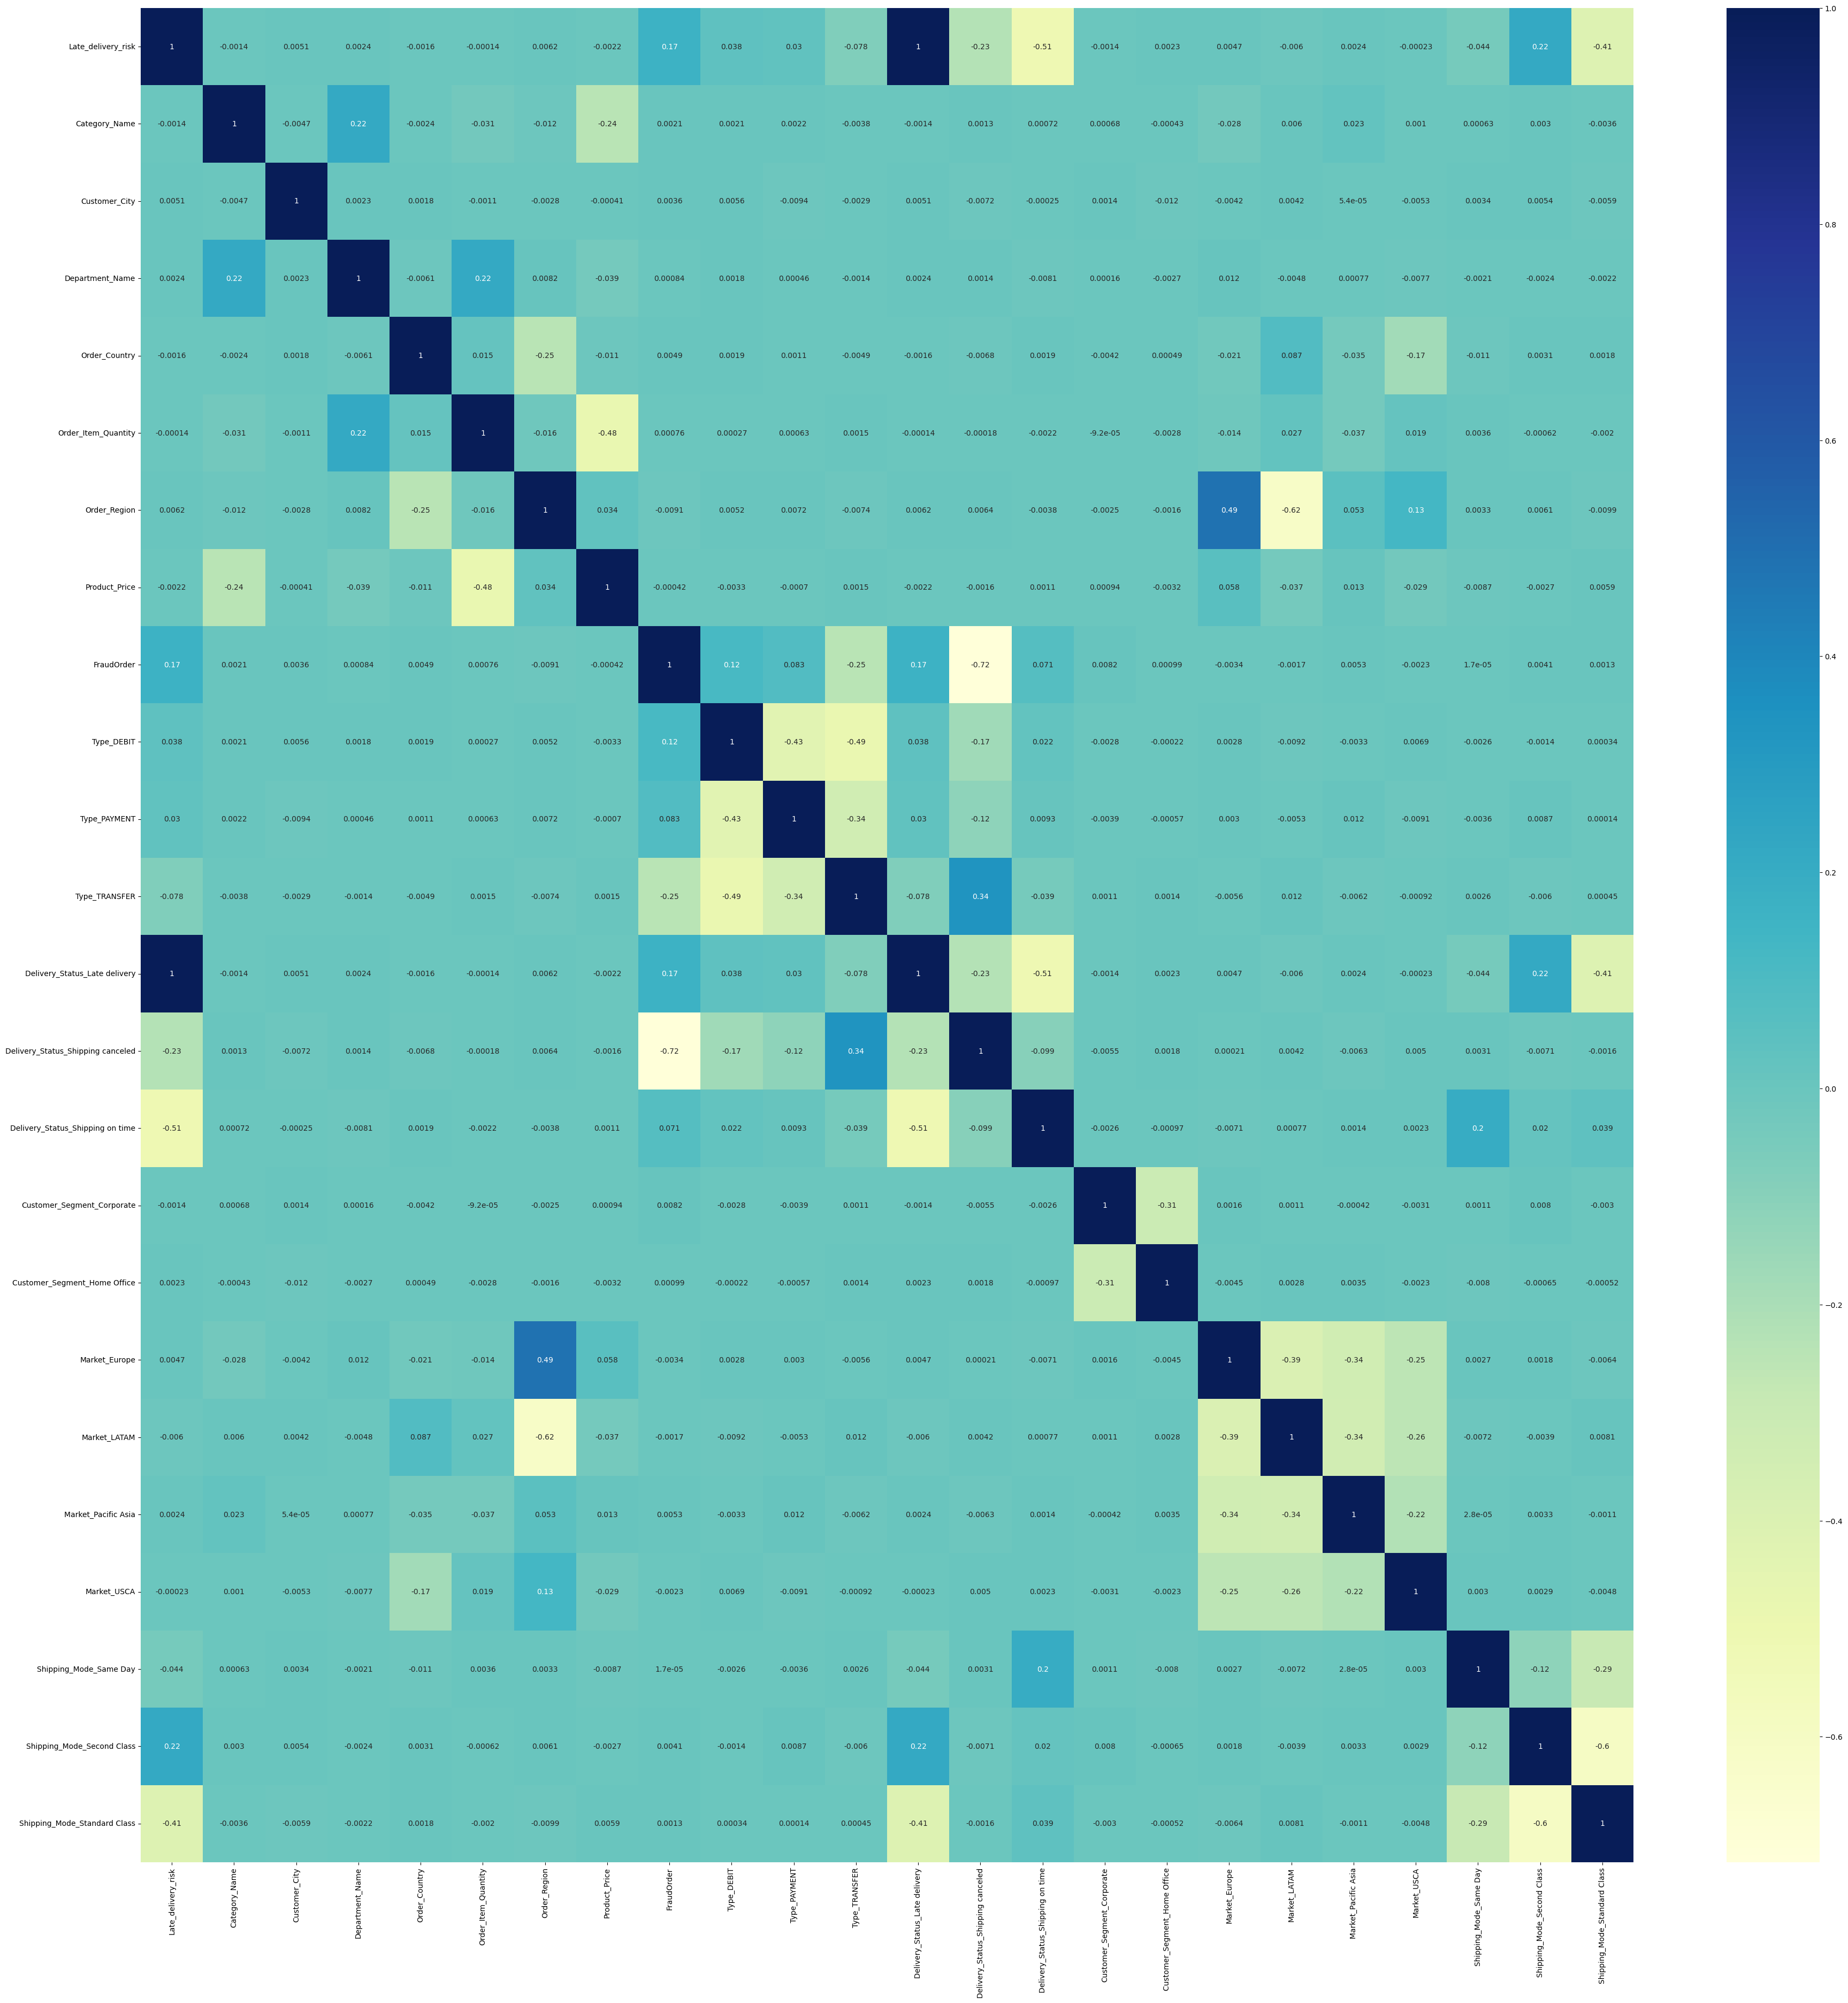

In [17]:
plt.figure(figsize=(45,45))
sns.heatmap(data.corr(),cmap="YlGnBu", annot=True)
plt.show()

In [18]:
data = data.drop(['Order_Item_Quantity'],axis=1)

In [19]:
data_features = data.drop('FraudOrder',axis=1)
vif_data = pd.DataFrame()
vif_data["feature"] = data_features.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(data_features.values, i)
                          for i in range(len(data_features.columns))]
print(vif_data)

C:\Users\Ahmed-Basem\Anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


                              feature       VIF
0                  Late_delivery_risk       inf
1                       Category_Name  4.750203
2                       Customer_City  2.389147
3                     Department_Name  2.778429
4                       Order_Country  3.305366
5                        Order_Region  6.931036
6                       Product_Price  2.079944
7                          Type_DEBIT  3.985819
8                        Type_PAYMENT  2.805641
9                       Type_TRANSFER  3.329490
10      Delivery_Status_Late delivery       inf
11  Delivery_Status_Shipping canceled  1.342253
12   Delivery_Status_Shipping on time  1.868460
13         Customer_Segment_Corporate  1.564815
14       Customer_Segment_Home Office  1.332559
15                      Market_Europe  4.892833
16                       Market_LATAM  3.984389
17                Market_Pacific Asia  3.605105
18                        Market_USCA  2.701669
19             Shipping_Mode_Same Day  1

In [20]:
normal_data = data[data['FraudOrder'] == 1]
anomalous_data = data[data['FraudOrder'] == -1]

In [21]:
normal_train , normal_test = train_test_split(normal_data,test_size= .05,random_state=42)
normal_train.shape , normal_test.shape

((167634, 23), (8823, 23))

In [22]:
test_data = pd.concat([normal_test,anomalous_data],axis=0)
test_data.head()

,Late_delivery_risk,Category_Name,Customer_City,Department_Name,Order_Country,Order_Region,Product_Price,FraudOrder,Type_DEBIT,Type_PAYMENT,...,Delivery_Status_Shipping on time,Customer_Segment_Corporate,Customer_Segment_Home Office,Market_Europe,Market_LATAM,Market_Pacific Asia,Market_USCA,Shipping_Mode_Same Day,Shipping_Mode_Second Class,Shipping_Mode_Standard Class
78893,1,46,411,3,48,18,199.990005,1,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
166083,1,34,314,0,108,11,129.990005,1,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
60499,0,9,447,3,102,3,299.980011,1,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
69812,0,10,266,5,48,18,99.989998,1,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
124127,1,15,66,0,31,7,461.480011,1,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [23]:
x_normal_train = normal_train.drop('FraudOrder',axis=1)

In [24]:
x_test = test_data.drop('FraudOrder',axis=1)
y_test = test_data['FraudOrder']
list(y_test).count(1) , list(y_test).count(-1)

(8823, 4062)

In [25]:
scaler = StandardScaler()

In [26]:
x_test.columns

Index(['Late_delivery_risk', 'Category_Name', 'Customer_City',
       'Department_Name', 'Order_Country', 'Order_Region', 'Product_Price',
       'Type_DEBIT', 'Type_PAYMENT', 'Type_TRANSFER',
       'Delivery_Status_Late delivery', 'Delivery_Status_Shipping canceled',
       'Delivery_Status_Shipping on time', 'Customer_Segment_Corporate',
       'Customer_Segment_Home Office', 'Market_Europe', 'Market_LATAM',
       'Market_Pacific Asia', 'Market_USCA', 'Shipping_Mode_Same Day',
       'Shipping_Mode_Second Class', 'Shipping_Mode_Standard Class'],
      dtype='object')

In [27]:
x_normal_train = scaler.fit_transform(x_normal_train)

In [28]:
joblib.dump(scaler,"utils/scaler.joblib")

['utils/scaler.joblib']

In [303]:
x_test = scaler.transform(x_test)

C:\Users\Ahmed-Basem\Anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [27]:
models = {"SVM":OneClassSVM(kernel='rbf', nu=0.05),
         "IsolationForest":IsolationForest(n_estimators=500, max_samples='auto', contamination=float(0.1), random_state=42)}

In [28]:
# for name,my_model in models.items():
#     print("\n",name)
#     my_model.fit(x_normal_train)
#     y_pred = model.predict(x_test)
#     print("\nAccuracy ", accuracy_score(y_pred,y_test))
#     print("\nPrecision", precision_score(y_pred,y_test))
#     print("\nRecall", recall_score(y_pred,y_test))
#     print("\nF1 Score", f1_score(y_pred,y_test))
#     print("\nClassification Report",classification_report(y_pred,y_test))

In [29]:
model = OneClassSVM(kernel='rbf', nu=0.05)
model.fit(x_normal_train)
y_pred = model.predict(x_test)
print("\nAccuracy ", accuracy_score(y_pred,y_test))
print("\nPrecision", precision_score(y_pred,y_test))
print("\nRecall", recall_score(y_pred,y_test))
print("\nF1 Score", f1_score(y_pred,y_test))
print("\nClassification Report",classification_report(y_pred,y_test))


Accuracy  0.8244470314318976

Precision 0.9518304431599229

Recall 0.8205178309721544

F1 Score 0.8813096862210095

Classification Report               precision    recall  f1-score   support

          -1       0.55      0.84      0.66      2650
           1       0.95      0.82      0.88     10235

    accuracy                           0.82     12885
   macro avg       0.75      0.83      0.77     12885
weighted avg       0.87      0.82      0.84     12885



In [34]:
joblib.dump(model,"utils/oneSVM.joblib")

['utils/oneSVM.joblib']

In [30]:
model = IsolationForest(n_estimators=400, max_samples='auto', contamination=float(0.1), random_state=42)
model.fit(x_normal_train)
y_pred = model.predict(x_test)
print("\nAccuracy ", accuracy_score(y_pred,y_test))
print("\nPrecision", precision_score(y_pred,y_test))
print("\nRecall", recall_score(y_pred,y_test))
print("\nF1 Score", f1_score(y_pred,y_test))
print("\nClassification Report",classification_report(y_pred,y_test))


Accuracy  0.8277066356228172

Precision 0.8996939816388984

Recall 0.8560336460692333

F1 Score 0.8773209549071619

Classification Report               precision    recall  f1-score   support

          -1       0.67      0.75      0.71      3612
           1       0.90      0.86      0.88      9273

    accuracy                           0.83     12885
   macro avg       0.79      0.81      0.79     12885
weighted avg       0.84      0.83      0.83     12885



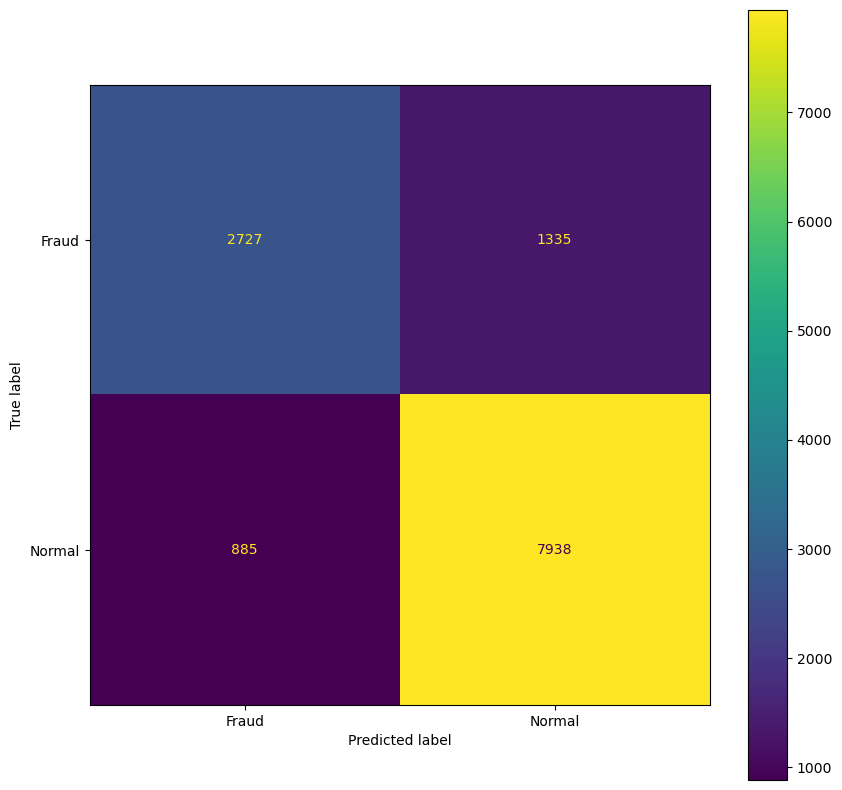

In [31]:
fig,ax = plt.subplots(figsize=(10,10))
confusion = confusion_matrix(y_test, y_pred)
display_con = ConfusionMatrixDisplay(confusion,display_labels=['Fraud',"Normal"])
display_con.plot(ax=ax)
plt.show()

In [29]:
data_s = {
    "Type": "TRANSFER",
    "Delivery_Status": "Shipping canceled",
    "Late_delivery_risk": 0,
    "Category_Name": "Sporting Goods",
    "Customer_City": "Caguas",
    "Customer_Segment": "Corporate",
    "Department_Name": "Fitness",
    "Market": "USCA",
    "Order_Country": "Australia",
    "Order_Region": "Oceania",
    "Product_Price": 327.75,
    "Shipping_Mode": "Second Class"
}
data = pd.DataFrame([data_s])
# data = pd.concat([data,data],axis=0)
data.head()

,Type,Delivery_Status,Late_delivery_risk,Category_Name,Customer_City,Customer_Segment,Department_Name,Market,Order_Country,Order_Region,Product_Price,Shipping_Mode
0,TRANSFER,Shipping canceled,0,Sporting Goods,Caguas,Corporate,Fitness,USCA,Australia,Oceania,327.75,Second Class


In [1]:
# joblib.load("utils/encoders.joblib")

In [2]:
# for col,encoder in joblib.load("utils/encoders.joblib").items():
#     data[col] = encoder.transform(data[col])

# hot_encoder = joblib.load("utils/hot_encoder.joblib")
# encoded_data = pd.DataFrame(hot_encoder.transform(data[cat_cols]))
# encoded_data.columns = hot_encoder.get_feature_names(cat_cols)
# data = pd.concat([data, encoded_data], axis=1)

# data = data.drop(cat_cols, axis=1)

# scaler = joblib.load("utils/scaler.joblib")
# data = scaler.transform(data)

# model = joblib.load("utils/oneSVM.joblib")

# prediction = model.predict(data)

In [36]:
prediction

array([-1])

In [37]:
data.columns

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
'Late_delivery_risk', 'Category_Name', 'Customer_City',
       'Department_Name', 'Order_Country', 'Order_Region', 'Product_Price',
       'Type_DEBIT', 'Type_PAYMENT'